In [1]:
from build_models import Discriminator,Generator,Adversarial
from Init import Mnist_load
# from CGAN import CGAN

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os  
import math 

from tensorflow.keras.datasets import mnist 
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow import keras

In [2]:
#파라미터 설정 및 데이터 로드 
data,params,Shape,learning = Mnist_load()
(x_train, y_train)  = data 
(batch_size, latent_size, train_steps, num_labels, model_name) = params
(input_shape,image_size,label_shape) = Shape
(lr,decay) = learning

#input & condition 
image_inputs = Input(shape=input_shape,name = "discriminator_input") #image input 
labels = Input(shape=label_shape,name=  'class_labels') # condition input 

#식별자 모델 
discriminator = Discriminator(image_inputs,labels,image_size).build_dicriminator()
d_optimizer = RMSprop(learning_rate=lr, decay = decay)
discriminator.compile(loss = 'binary_crossentropy',
                        optimizer = d_optimizer,
                        metrics = ['accuracy'])
discriminator.trainable=False

#생성자 모델 
input_shape = (latent_size,)
noise_input = Input(shape=input_shape, name= 'z_input') #noise input 
generator = Generator(noise_input, labels, image_size).build_generator()
g_optimizer = RMSprop(learning_rate=lr*0.5, decay = decay*0.5)

#대립 모델 
adversarial = Adversarial(generator,discriminator,noise_input,labels,g_optimizer).build_adversarial()
adversarial.compile(loss = 'binary_crossentropy',
                    optimizer = g_optimizer,
                    metrics = ['accuracy'])
models = (adversarial,generator,discriminator)

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
import math 

class CGAN():
    def __init__(self,models,data,params):
        (self.x_train, self.y_train)  = data 
        (self.batch_size, self.latent_size, self.train_steps, self.num_labels, self.model_name) = params
        (self.adversarial,self.generator,self.discriminator) = models
        #학습 중간 확인 용 valid 데이터 
        self.valid_noise_input = np.random.uniform(-1.0,1.0,size=[16,self.latent_size]) #shape = (16,100)
        self.valid_condition = np.eye(self.num_labels)[np.arange(0,16) % self.num_labels] #원 핫 벡터 형태
        #학습 총 데이터 양 
        self.train_size = self.x_train.shape[0] #60000
        self.save_interval =500
        print(self.model_name,"labels for generated images:",np.argmax(self.valid_condition,axis=1)) #원핫인코딩 -> 카테고리컬 인코딩 

    def plot_images(self):
        images = self.generator.predict([self.valid_noise_input,self.valid_condition])
        num_images = images.shape[0] #16
        image_size = images.shape[1] #28

        plt.figure(figsize=(2.2, 2.2))
        rows = int(math.sqrt(self.valid_noise_input.shape[0]))
        for i in range(num_images):
            image = np.reshape(images[i], [image_size, image_size])
            plt.subplot(rows, rows, i + 1)
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.show()

    def create_data(self):
        #진짜 데이터 생성 
        rand_indexes = np.random.randint(0,self.train_size,size=self.batch_size)#6만개 중 16개 선택 
        real_images = self.x_train[rand_indexes]
        real_labels = self.y_train[rand_indexes] #진짜 레이블 (조건)

        #가짜 데이터 생성 
        noise = np.random.uniform(-1.0,1.0, size=[self.batch_size,self.latent_size]) #(64,100)형태로 노이즈 만듬
        fake_labels = np.eye(self.num_labels)[np.random.choice(self.num_labels,self.batch_size)] #가짜 레이블(조건)
        fake_images = self.generator.predict([noise,fake_labels]) #조건 + 노이즈 +생성기 -> 가짜 이미지

        #훈련 데이터 생성 = 진짜 데이터 + 가짜 데이터 
        x = np.concatenate((real_images, fake_images)) #shape = (128,28,28,1)
        condition = np.concatenate((real_labels,fake_labels)) #shape = (128,10) 원핫인코딩라벨 

        y = np.ones([2*self.batch_size,1])
        y[self.batch_size:,:] = 0 #카테고리컬 라벨링 shape = (128,1)
        
        return x,y,condition
        
    def train(self):
        for i in range(self.train_steps):

            """
            discriminator metric
            """
            #평가용 데이터 로드 
            x,y,condition = self.create_data()

            #판별기 네트워크 훈련, 손실과 정확도 기록 
            loss,acc = self.discriminator.train_on_batch([x,condition],y)
            log = "%d : [discriminator loss : %f, acc: %f]" % (i,loss,acc)

            """
            adversarial 
            """
            # 생성자 input 생성 
            noise = np.random.uniform(-1.0,1.0,size = [self.batch_size,self.latent_size]) #noise shape = 64,100
            condition = np.eye(self.num_labels)[np.random.choice(self.num_labels,self.batch_size)] #condition 64,10

            # 생성자 output 생성 
            y = np.ones([self.batch_size,1]) #shape = 64,1

            # 적대적 신경망 학습 및 평가 
            loss,acc = self.adversarial.train_on_batch([noise,condition],y)
            log = "%s [adversarial loss :%f, acc :%f" % (log,loss,acc)
            
            if (i+1) % self.save_interval == 0:
                print(log)
                self.plot_images()
                            
        self.generator.save(f'{self.model_name}.h5')

cgan_mnist labels for generated images: [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5]
499 : [discriminator loss : 0.549063, acc: 0.882812] [adversarial loss :1.251083, acc :0.000000


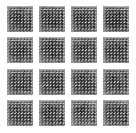

999 : [discriminator loss : 0.240418, acc: 0.906250] [adversarial loss :1.376896, acc :0.109375


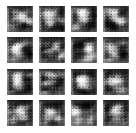

1499 : [discriminator loss : 0.070131, acc: 0.984375] [adversarial loss :0.009002, acc :1.000000


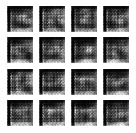

1999 : [discriminator loss : 0.001174, acc: 1.000000] [adversarial loss :0.000001, acc :1.000000


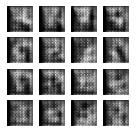

2499 : [discriminator loss : 0.008515, acc: 1.000000] [adversarial loss :0.414867, acc :0.796875


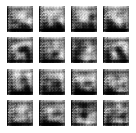

2999 : [discriminator loss : 0.002804, acc: 1.000000] [adversarial loss :0.009899, acc :1.000000


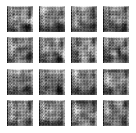

3499 : [discriminator loss : 0.723178, acc: 0.492188] [adversarial loss :1.112752, acc :0.093750


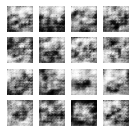

3999 : [discriminator loss : 0.449533, acc: 0.796875] [adversarial loss :1.674578, acc :0.031250


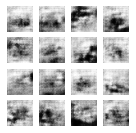

4499 : [discriminator loss : 0.448077, acc: 0.804688] [adversarial loss :1.400329, acc :0.234375


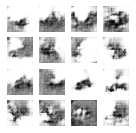

4999 : [discriminator loss : 0.603666, acc: 0.632812] [adversarial loss :1.407080, acc :0.062500


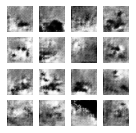

5499 : [discriminator loss : 0.296050, acc: 0.859375] [adversarial loss :1.879418, acc :0.062500


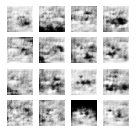

5999 : [discriminator loss : 0.669864, acc: 0.578125] [adversarial loss :0.776519, acc :0.312500


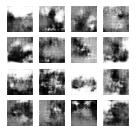

6499 : [discriminator loss : 0.652616, acc: 0.593750] [adversarial loss :0.790054, acc :0.281250


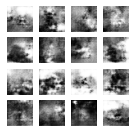

6999 : [discriminator loss : 0.624932, acc: 0.695312] [adversarial loss :0.859373, acc :0.187500


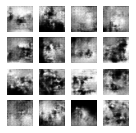

7499 : [discriminator loss : 0.459341, acc: 0.804688] [adversarial loss :0.852973, acc :0.375000


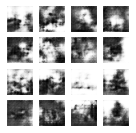

7999 : [discriminator loss : 0.625099, acc: 0.718750] [adversarial loss :1.772645, acc :0.203125


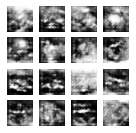

8499 : [discriminator loss : 0.166609, acc: 0.945312] [adversarial loss :1.351298, acc :0.250000


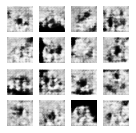

8999 : [discriminator loss : 0.247521, acc: 0.890625] [adversarial loss :1.335340, acc :0.203125


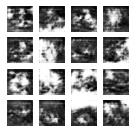

9499 : [discriminator loss : 0.611571, acc: 0.695312] [adversarial loss :1.455778, acc :0.078125


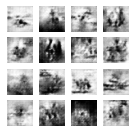

9999 : [discriminator loss : 0.267395, acc: 0.890625] [adversarial loss :0.151292, acc :0.937500


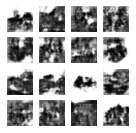

10499 : [discriminator loss : 0.388848, acc: 0.812500] [adversarial loss :1.034693, acc :0.515625


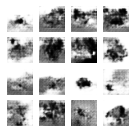

10999 : [discriminator loss : 0.478346, acc: 0.765625] [adversarial loss :1.657205, acc :0.218750


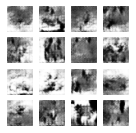

11499 : [discriminator loss : 0.349016, acc: 0.890625] [adversarial loss :0.523723, acc :0.734375


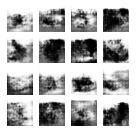

11999 : [discriminator loss : 0.426690, acc: 0.765625] [adversarial loss :2.778387, acc :0.015625


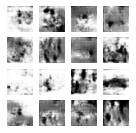

12499 : [discriminator loss : 0.326283, acc: 0.882812] [adversarial loss :0.519409, acc :0.781250


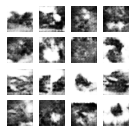

12999 : [discriminator loss : 0.152852, acc: 0.953125] [adversarial loss :2.247453, acc :0.093750


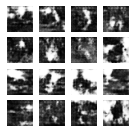

13499 : [discriminator loss : 0.587732, acc: 0.679688] [adversarial loss :1.488769, acc :0.062500


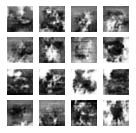

13999 : [discriminator loss : 0.484427, acc: 0.789062] [adversarial loss :0.695996, acc :0.609375


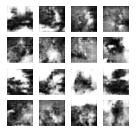

14499 : [discriminator loss : 0.457975, acc: 0.757812] [adversarial loss :1.692768, acc :0.078125


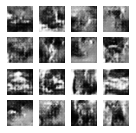

14999 : [discriminator loss : 0.303556, acc: 0.867188] [adversarial loss :0.689423, acc :0.578125


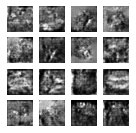

15499 : [discriminator loss : 0.428951, acc: 0.796875] [adversarial loss :2.153369, acc :0.156250


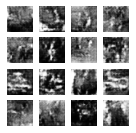

15999 : [discriminator loss : 0.465668, acc: 0.789062] [adversarial loss :2.023823, acc :0.234375


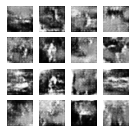

16499 : [discriminator loss : 0.761921, acc: 0.617188] [adversarial loss :0.781266, acc :0.562500


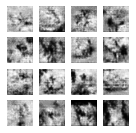

16999 : [discriminator loss : 0.226366, acc: 0.898438] [adversarial loss :0.108891, acc :0.953125


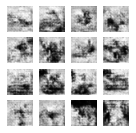

17499 : [discriminator loss : 0.178648, acc: 0.914062] [adversarial loss :1.913594, acc :0.187500


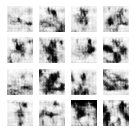

17999 : [discriminator loss : 0.330162, acc: 0.851562] [adversarial loss :1.363948, acc :0.328125


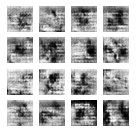

18499 : [discriminator loss : 0.424745, acc: 0.789062] [adversarial loss :3.290763, acc :0.125000


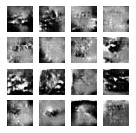

18999 : [discriminator loss : 0.248679, acc: 0.906250] [adversarial loss :7.809966, acc :0.015625


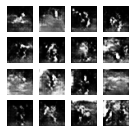

19499 : [discriminator loss : 0.519370, acc: 0.750000] [adversarial loss :0.484456, acc :0.812500


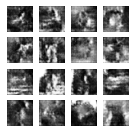

19999 : [discriminator loss : 0.553053, acc: 0.695312] [adversarial loss :0.342997, acc :0.859375


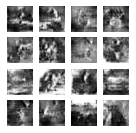

20499 : [discriminator loss : 0.145310, acc: 0.929688] [adversarial loss :0.068367, acc :0.984375


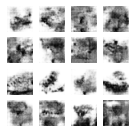

20999 : [discriminator loss : 0.291975, acc: 0.851562] [adversarial loss :1.220010, acc :0.546875


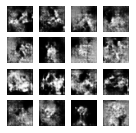

21499 : [discriminator loss : 0.138400, acc: 0.953125] [adversarial loss :6.380682, acc :0.000000


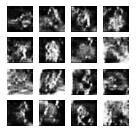

21999 : [discriminator loss : 0.212724, acc: 0.906250] [adversarial loss :2.633929, acc :0.015625


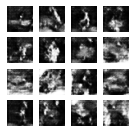

22499 : [discriminator loss : 0.279579, acc: 0.882812] [adversarial loss :0.517352, acc :0.781250


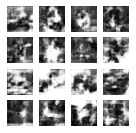

22999 : [discriminator loss : 0.400389, acc: 0.820312] [adversarial loss :0.750102, acc :0.625000


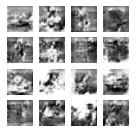

KeyboardInterrupt: 

In [4]:
cgan = CGAN(models,data,params)
cgan.train()